In [1]:
import yfinance as yf
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import warnings
warnings.filterwarnings('ignore')

# ✅ 한글 폰트 설정
def set_korean_font():
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = fm.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    # 한글 폰트 적용
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

# ✅ 주가 데이터 불러오기
def load_stock_data(ticker, months=18):
    today = date.today()
    startD = today - relativedelta(months=months)
    endD = today
    return yf.download(ticker, startD, endD)

# ✅ 수익률 평균과 표준편차 계산
def calc_return_stats(stock_data):
    returns = stock_data['Close'].pct_change().dropna()
    mu = returns.mean()
    sigma = returns.std()
    return mu, sigma

import numpy as np
import matplotlib.pyplot as plt

def calc_basis_risk_distribution(price_lists, jump_indices_list, insurance_payments, trigger_rate):
    basis_risks = []
    actual_losses = []
    paid_amounts = []
    for sim_idx, (price_list, jump_indices, payment) in enumerate(zip(price_lists, jump_indices_list, insurance_payments)):
        if jump_indices:
            for jump_idx in jump_indices:
                price_before = price_list[jump_idx]
                if jump_idx+1 < len(price_list):
                    price_after = price_list[jump_idx+1]
                    trigger_price = price_before * (1 - trigger_rate)
                    actual_loss = price_before - price_after
                    # 조건: 트리거 미만 하락 & 실제 손실 > 0 & 보험금 > 0
                    if (price_after < trigger_price) and (actual_loss > 0) and (payment > 0):
                        paid = min(payment, actual_loss)
                        coverage_ratio = paid / actual_loss
                        # 보상률 0인 경우 제외
                        if coverage_ratio > 0:
                            basis_risk = 1 - coverage_ratio
                            basis_risks.append(basis_risk)
                            actual_losses.append(actual_loss)
                            paid_amounts.append(paid)
    return np.array(basis_risks), np.array(actual_losses), np.array(paid_amounts)

def plot_basis_risk_stats(basis_risks):
    import seaborn as sns
    
    set_korean_font()
    
    # 1. 히스토그램
    plt.figure(figsize=(10,5))
    plt.hist(basis_risks, bins=30, color='skyblue', edgecolor='k', alpha=0.8)
    plt.title('베이시스 리스크(1-보상률) 분포 (히스토그램)')
    plt.xlabel('베이시스 리스크 (0=완전보상, 1=미보상)')
    plt.ylabel('빈도')
    plt.grid(True, alpha=0.3)
    plt.show()

    # 2. 누적분포(CDF)
    plt.figure(figsize=(10,5))
    sorted_risk = np.sort(basis_risks)
    cdf = np.arange(1, len(sorted_risk)+1) / len(sorted_risk)
    plt.plot(sorted_risk, cdf, marker='.', linestyle='-')
    plt.title('베이시스 리스크 누적분포(CDF)')
    plt.xlabel('베이시스 리스크')
    plt.ylabel('누적비율')
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3. 박스플롯
    plt.figure(figsize=(6,5))
    sns.boxplot(x=basis_risks, color='lightcoral')
    plt.title('베이시스 리스크 Boxplot')
    plt.xlabel('베이시스 리스크')
    plt.show()

    # 4. 요약 통계
    print("===== 베이시스 리스크 요약 통계 =====")
    print(f"평균: {np.mean(basis_risks):.3f}")
    print(f"중앙값: {np.median(basis_risks):.3f}")
    print(f"상위 10% (90% 이상): {np.percentile(basis_risks, 90):.3f}")
    print(f"상위 25% (Q3): {np.percentile(basis_risks, 75):.3f}")
    print(f"하위 25% (Q1): {np.percentile(basis_risks, 25):.3f}")
    print(f"최소값: {np.min(basis_risks):.3f}")
    print(f"최대값: {np.max(basis_risks):.3f}")
    print(f"0.8 이상 비율: {(basis_risks >= 0.8).mean()*100:.1f}%")
    print(f"0.9 이상 비율: {(basis_risks >= 0.9).mean()*100:.1f}%")


In [3]:

# ✅ 몬테카를로 시뮬레이션
def run_loss_simulations( ticker, num_simulations=100, T=252, lambda_event=0.13, jump_mu=-0.01, jump_vol=0.045, trigger_rate=0.05, epsilon = 0.006 ):
    print(f"""
    시뮬레이션 입력값:
    - 종목코드: {ticker}
    - 시뮬레이션 횟수: {num_simulations}회
    - 시뮬레이션 기간: {T}일
    - 연간 점프 발생률(λ): {lambda_event*252:.3f}회
    - 점프 크기 평균(μ): {jump_mu:.3%}
    - 점프 크기 변동성(σ): {jump_vol:.3%}
    - 트리거 비율: {trigger_rate:.1%}
    - 일일 보험료율: {epsilon:.3%}
    """)
    df = pd.DataFrame()
    last_price_list = []
    jump_indices_list = []  # 점프 발생 인덱스 리스트 
    count_jump = []
    insurance_payments = []  # 보험금 지급 리스트
    insurance_premiums = []  # 보험료 납입 리스트
    lambda_event = lambda_event / 252
    
    KOFR = 0.0258     # KOFR 2.581%
    i = KOFR / 252
    
    stock_data = load_stock_data(ticker)
    last_price = int(stock_data['Close'].iloc[-1])
    mu, daily_vol = calc_return_stats(stock_data)

    for _i_ in range(num_simulations):
        count = 0
        price_list = []
        price = int(last_price * (1 + np.random.normal(mu, daily_vol)))
        price_list.append(price)
        jump_indices = []  # 각 시뮬레이션별 점프 인덱스
        insurance_payment = 0  # 보험금 지급액
        insurance_premium = 0  # 보험료 납입액
        trigger_price = None  # 트리거 가격
        triggered = False

        for t in range(T):
            if not triggered:  # 보험금 수령 전까지만 보험료 납입
                temp = last_price * epsilon / 252# 일일 보험료 납입
                insurance_premium += temp * (1 + i) ** -t
                
            if triggered:
                price = trigger_price
            else:
                event = np.random.poisson(lambda_event)
                if event >= 1:
                    jump_return = np.random.normal(jump_mu , jump_vol)
                    price_before_jump = price_list[count]
                    trigger_price = int(price_before_jump * (1 - trigger_rate))
                    price = int(price_before_jump * (1 - abs(jump_return)))
                    
                    # 포아송 하락 점프로 인해 트리거 가격 이하로 떨어진 경우
                    if jump_return < 0 and price < trigger_price:
                        insurance_payment = trigger_price - price  # 손실액 보전
                        print(f'sim{_i_}에서 {t}일차에 보험금 지급발생!: {insurance_payment}')
                        price = trigger_price  # 보험금 지급 후 가격은 트리거 가격
                        triggered = True
                    jump_indices.append(count)
                else:
                    price =int(price_list[count] * (1 + np.random.normal(mu, daily_vol)))
            
            price_list.append(price)
            count += 1

        df[len(df.columns)] = price_list
        last_price_list.append(price_list[-1])
        jump_indices_list.append(jump_indices)
        count_jump.append(len(jump_indices))
        insurance_payments.append(insurance_payment)
        insurance_premiums.append(insurance_premium)

    return ticker, df, last_price_list, jump_indices_list, count_jump, insurance_payments, insurance_premiums


In [4]:
# ✅ 메인 함수 (종목코드 ticker를 인자로 받음)
def viz_loss(ticker, params):

    # 시뮬레이션 실행
    _, price_df, last_price_list, jump_indices_list, count_jump, insurance_payments, insurance_premiums = run_loss_simulations(
        ticker=ticker,
        num_simulations=params['num_simulations'], 
        T=params['T'], 
        lambda_event=params['lambda_event'], 
        jump_mu=params['jump_mu'], 
        jump_vol=params['jump_vol'],
        trigger_rate=params['trigger_rate'], 
        epsilon=params['epsilon'])

        # price_lists: 각 시뮬레이션별 가격 리스트
    price_lists = price_df.values.T.tolist()
        
        # 1-보상률(베이시스 리스크) 분포 계산
    basis_risks, actual_losses, paid_amounts = calc_basis_risk_distribution(price_lists, jump_indices_list, insurance_payments, params['trigger_rate'])

        # 시각화 및 통계
    plot_basis_risk_stats(basis_risks)
    
    # 보험금 분포 시각화 및 통계량 계산
    plt.figure(figsize=(8, 6))
    # array 형태의 값을 int로 변환
    payments = [int(p[0]) if isinstance(p, np.ndarray) else p for p in insurance_payments]
    # 95% VaR, 99% VaR 계산 (상위 5%, 1%)
    var_95 = np.percentile(payments, 95)   # 상위 5% 지점
    var_99 = np.percentile(payments, 99)   # 상위 1% 지점

    # 평균과 분산 계산
    mean_payment = np.mean(payments)
    var_payment = np.var(payments)
    
    # 서브플롯 생성
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # 왼쪽 그래프 - 전체 데이터
    ax1.boxplot(payments, widths=0.7)
    ax1.axhline(mean_payment, color='r', linestyle='dashed', linewidth=1, label=f'평균: {mean_payment:,.0f}원')
    ax1.set_title('전체 보험금 분포', fontsize=14)
    ax1.set_ylabel('Insurance Payment (KRW)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 오른쪽 그래프
    filtered_payments = payments # [p for p in payments if p != 0] > 0인 부분 제외할 때 이거 쓰기기
    ax2.hist(filtered_payments, bins=20)
    filtered_mean = np.mean(filtered_payments)
    ax2.axvline(filtered_mean, color='r', linestyle='dashed', linewidth=1, label=f'평균: {filtered_mean:,.0f}원')
    # VaR을 그래프에 표시
    ax1.axhline(var_95, color='g', linestyle='dotted', linewidth=1, label=f'95% VaR: {var_95:,.0f}원')
    ax1.axhline(var_99, color='b', linestyle='dotted', linewidth=1, label=f'99% VaR: {var_99:,.0f}원')
    # VaR을 그래프에 표시
    ax2.axvline(var_95, color='g', linestyle='dotted', linewidth=1, label=f'95% VaR: {var_95:,.0f}원')
    ax2.axvline(var_99, color='b', linestyle='dotted', linewidth=1, label=f'99% VaR: {var_99:,.0f}원')
    ax2.set_title('보험금 분포', fontsize=14)
    ax2.set_xlabel('Insurance Payment (KRW)', fontsize=12)
    ax2.set_ylabel('빈도 수', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 평균 보험료와 평균 보험금 비교 시각화
    plt.figure(figsize=(12, 6))


    # 데이터 준비
    mean_premium = np.mean(insurance_premiums)
    categories = ['평균 보험료', '평균 보험금']
    values = [mean_premium, mean_payment]

    # 막대 그래프 생성
    bars = plt.bar(categories, values, color=['lightblue', 'lightcoral'])

    # 막대 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}원',
                ha='center', va='bottom')

    plt.title('평균 보험료와 평균 보험금 비교', fontsize=14)
    plt.ylabel('금액 (KRW)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # 손해율 계산 및 표시
    loss_ratio = (mean_payment / mean_premium) * 100
    plt.text(0.5, max(values) * 1.1, 
            f'손해율: {loss_ratio:.1f}%',
            ha='center', fontsize=12)
    plt.show()
    
    print("===== 시뮬레이션 입력값 =====")
    for k, v in params.items():
        print(f"{k}: {v}")
    
    print("\n===== 시뮬레이션 주요 결과 =====")
    print(f"평균 보험금: {np.mean(payments):,.0f}원")
    print(f"평균 보험료: {np.mean(insurance_premiums):,.0f}원")
    print(f"손해율(평균 보험금/평균 보험료): {np.mean(payments)/np.mean(insurance_premiums)*100:.1f}%")
    print(f"보험금 지급 비율: {(np.array(payments)>0).mean()*100:.1f}%")
    print(f"보험금 미지급 비율: {(np.array(payments)==0).mean()*100:.1f}%")
    print(f"보험금 95% VaR: {var_95:,.0f}원")
    print(f"보험금 99% VaR: {var_99:,.0f}원")
    
    print("\n===== 베이시스 리스크 요약 통계 =====")
    print(f"평균: {np.mean(basis_risks):.3f}")
    print(f"중앙값: {np.median(basis_risks):.3f}")
    print(f"상위 10% (90% 이상): {np.percentile(basis_risks, 90):.3f}")
    print(f"상위 25% (Q3): {np.percentile(basis_risks, 75):.3f}")
    print(f"하위 25% (Q1): {np.percentile(basis_risks, 25):.3f}")
    print(f"최소값: {np.min(basis_risks):.3f}")
    print(f"최대값: {np.max(basis_risks):.3f}")
    print(f"0.8 이상 비율: {(basis_risks >= 0.8).mean()*100:.1f}%")
    print(f"0.9 이상 비율: {(basis_risks >= 0.9).mean()*100:.1f}%")
        


    시뮬레이션 입력값:
    - 종목코드: 066570.KS
    - 시뮬레이션 횟수: 100000회
    - 시뮬레이션 기간: 1260일
    - 연간 점프 발생률(λ): 32.760회
    - 점프 크기 평균(μ): -1.250%
    - 점프 크기 변동성(σ): 9.090%
    - 트리거 비율: 10.0%
    - 일일 보험료율: 0.125%
    
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


sim19에서 489일차에 보험금 지급발생!: 7051
sim27에서 145일차에 보험금 지급발생!: 2059
sim61에서 320일차에 보험금 지급발생!: 229
sim69에서 843일차에 보험금 지급발생!: 841
sim91에서 426일차에 보험금 지급발생!: 7292
sim145에서 819일차에 보험금 지급발생!: 3832
sim147에서 677일차에 보험금 지급발생!: 2691
sim148에서 43일차에 보험금 지급발생!: 4001
sim160에서 939일차에 보험금 지급발생!: 748
sim161에서 94일차에 보험금 지급발생!: 860
sim166에서 484일차에 보험금 지급발생!: 1167
sim175에서 334일차에 보험금 지급발생!: 2412
sim182에서 1144일차에 보험금 지급발생!: 504
sim233에서 986일차에 보험금 지급발생!: 3116
sim297에서 1134일차에 보험금 지급발생!: 68
sim307에서 455일차에 보험금 지급발생!: 1093
sim308에서 688일차에 보험금 지급발생!: 6063
sim329에서 1036일차에 보험금 지급발생!: 19
sim333에서 776일차에 보험금 지급발생!: 2733
sim347에서 581일차에 보험금 지급발생!: 5938
sim358에서 355일차에 보험금 지급발생!: 7076
sim359에서 178일차에 보험금 지급발생!: 1793
sim363에서 67일차에 보험금 지급발생!: 628
sim369에서 468일차에 보험금 지급발생!: 1864
sim390에서 634일차에 보험금 지급발생!: 707
sim395에서 1009일차에 보험금 지급발생!: 1101
sim402에서 756일차에 보험금 지급발생!: 710
sim404에서 453일차에 보험금 지급발생!: 1882
sim413에서 590일차에 보험금 지급발생!: 2576
sim421에서 231일차에 보험금 지급발생!: 3869
sim428에서 370일차에 보험금 지급발생!: 1442
sim452에서 656일차에 보험금 지급발생

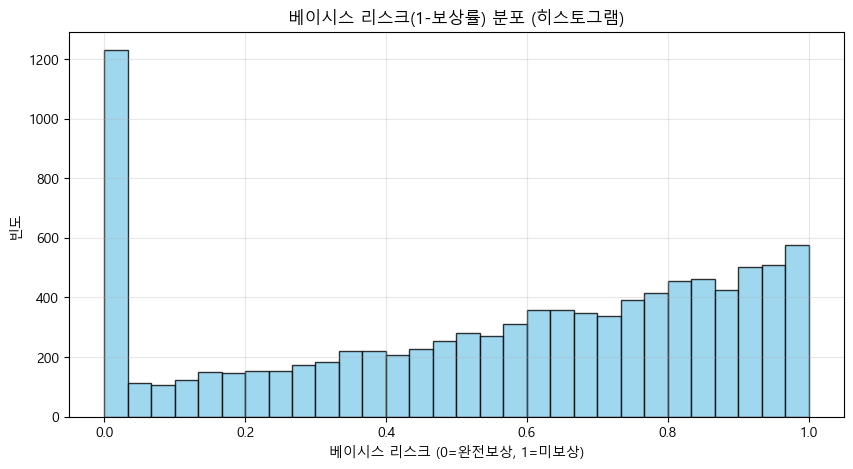

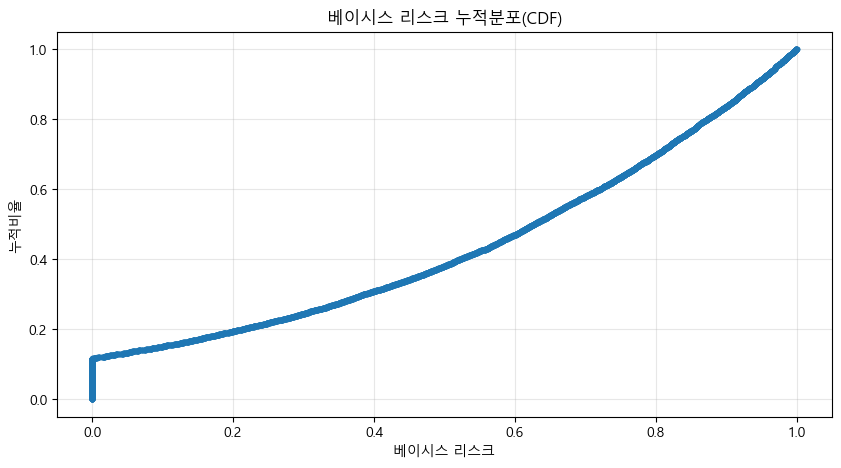

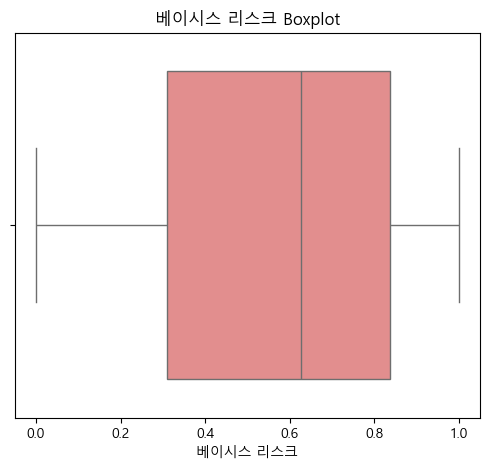

===== 베이시스 리스크 요약 통계 =====
평균: 0.560
중앙값: 0.628
상위 10% (90% 이상): 0.941
상위 25% (Q3): 0.838
하위 25% (Q1): 0.310
최소값: 0.000
최대값: 1.000
0.8 이상 비율: 30.3%
0.9 이상 비율: 16.4%


<Figure size 800x600 with 0 Axes>

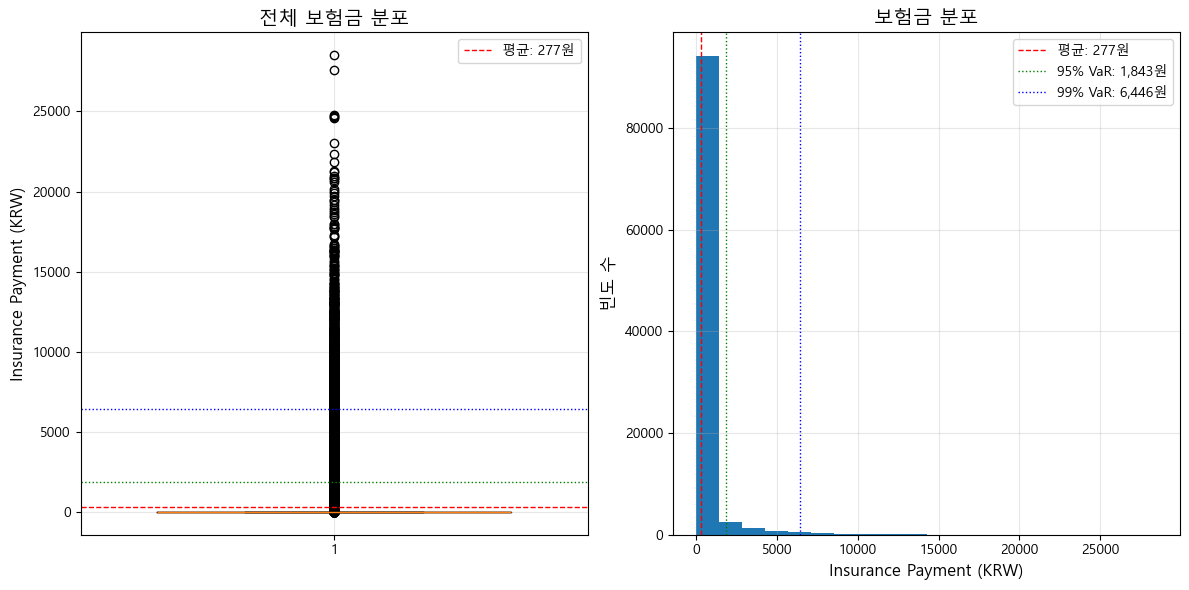

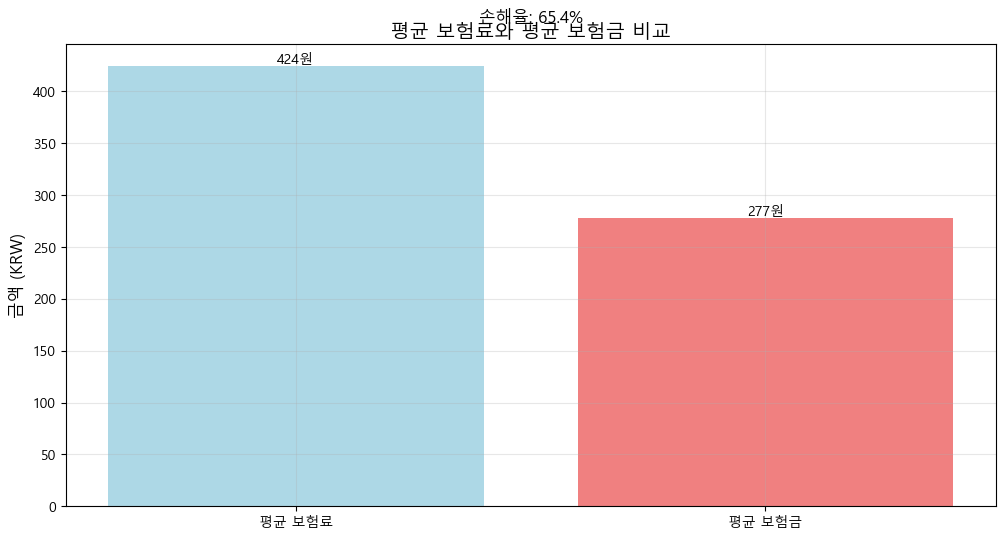

===== 시뮬레이션 입력값 =====
num_simulations: 100000
T: 1260
lambda_event: 0.13
jump_mu: -0.0125
jump_vol: 0.0909
trigger_rate: 0.1
epsilon: 0.00125

===== 시뮬레이션 주요 결과 =====
평균 보험금: 277원
평균 보험료: 424원
손해율(평균 보험금/평균 보험료): 65.4%
보험금 지급 비율: 10.3%
보험금 미지급 비율: 89.7%
보험금 95% VaR: 1,843원
보험금 99% VaR: 6,446원

===== 베이시스 리스크 요약 통계 =====
평균: 0.560
중앙값: 0.628
상위 10% (90% 이상): 0.941
상위 25% (Q3): 0.838
하위 25% (Q1): 0.310
최소값: 0.000
최대값: 1.000
0.8 이상 비율: 30.3%
0.9 이상 비율: 16.4%


In [5]:
# 시뮬레이션 파라미터 설정
params = {
    'num_simulations': 100000,  # 시뮬레이션 횟수
    'T': 252*5,               # 시뮬레이션 기간(거래일)
    'lambda_event': 0.13,   # 점프 발생 확률
    'jump_mu': -0.0125,       # 점프 크기의 평균 : 10일 평균
    'jump_vol': 0.0909,      # 점프 크기의 표준편차
    'trigger_rate': 0.10,   # 트리거 수익률
    'epsilon': 0.00125        # 보험요율
}


viz_loss('066570.KS', params) # LG전자